In [ ]:
#|hide
## Standard libraries
import os
import math
import numpy as np
import time
from fastcore.all import *
from nbdev.showdoc import *

# Configure environment
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false' # Tells Jax not to hog all of the memory to this process.
import nest_asyncio
nest_asyncio.apply()

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm, trange

from functools import partial

## project specifics
import diffusion_curvature
import pygsp
import jax
import jax.numpy as jnp
from diffusion_curvature.graphs import *
from diffusion_curvature.datasets import *
from diffusion_curvature.core import *
from diffusion_curvature.utils import *
# from diffusion_curvature.comparison_space import *
from diffusion_curvature.sadspheres import *
from diffusion_curvature.kernels import *

%load_ext autoreload
%autoreload 2
    
jax.devices()
# jax.default_device = jax.devices("cpu")

[cuda(id=0), cuda(id=1)]

# Sign Prediction Tests
> Comparisons between Diffusion Curvature and the Competition

Here we employ saddles and spheres of increasing dimension to test our model's ability to detect sign.

# Machinery

In [ ]:
dims = [2, 3, 4, 5, 6]
num_pointclouds = 20

In [ ]:
SS1 = SadSpheres(
    dimension = dims, # Dimension of saddles and spheres
    num_pointclouds = num_pointclouds, # num pointclouds to make in total
    num_points = 2000, # num points per pointclouds
    noise_level = 0, # from 0 to 1. 1 is all noise.
    include_planes=True,
)

Loaded evaluations on methods ['ground truth', 'Diffusion Curvature (Entropic)', 'Diffusion Curvature (Wasserstein)', 'Hickok & Blumberg', 'Diffusion Curvature (Trajectory Normalized)', 'Diffusion Curvature (Trajectory Normalized w/ Anisotropy)', 'Diffusion Curvature (Trajectory Normalized w/ Smaller Bandwidth)', 'Diffusion Curvature (Trajectory Normalized w/ Smaller Bandwidth, Many ts)', 'Diffusion Curvature (Trajectory Normalized w/ Smaller Bandwidth, Many more ts)']


In [ ]:
SS1.imported_methods

['ground truth',
 'Diffusion Curvature (Entropic)',
 'Diffusion Curvature (Wasserstein)',
 'Hickok & Blumberg',
 'Diffusion Curvature (Trajectory Normalized)',
 'Diffusion Curvature (Trajectory Normalized w/ Anisotropy)',
 'Diffusion Curvature (Trajectory Normalized w/ Smaller Bandwidth)',
 'Diffusion Curvature (Trajectory Normalized w/ Smaller Bandwidth, Many ts)',
 'Diffusion Curvature (Trajectory Normalized w/ Smaller Bandwidth, Many more ts)']

In [ ]:
# SS1.delete_saved_method('Diffusion Curvature (Trajectory Normalized)')

Deleted method from saved results


In [ ]:
SS1.save_results()

In [ ]:
# graph_former = partial(get_curvature_agnostic_graph, k = dim*2, )
graph_former = partial(get_fixed_graph, sigma = 0.2, alpha = 1)
for X in tqdm(SS1):
    if "Diffusion Curvature (Entropic)" not in SS1.imported_methods:
        G = graph_former(X)
        DC = DiffusionCurvature(
            laziness_method="Wasserstein",
            flattening_method="Fixed",
            comparison_method="Ollivier",
            graph_former = graph_former,
            points_per_cluster=None,  # construct separate comparison spaces around each point
            comparison_space_size_factor=1,
        )
        ks = DC.curvature(G, dim = X.shape[1] - 1, t = 25)
        SS1.update(ks[0], method_name="Diffusion Curvature (Entropic)")
    if "Diffusion Curvature (Wasserstein)" not in SS1.imported_methods:
        G = graph_former(X)
        DC = DiffusionCurvature(
            laziness_method="Entropic",
            flattening_method="Fixed",
            comparison_method="Subtraction",
            graph_former = graph_former,
            points_per_cluster=None,  # construct separate comparison spaces around each point
            comparison_space_size_factor=1,
        )
        ks = DC.curvature(G, dim = X.shape[1] - 1, t = 25)
        SS1.update(ks[0], method_name="Diffusion Curvature (Wasserstein)")
    if "Diffusion Curvature (Trajectory Normalized w/ Smaller Bandwidth k =1)" not in SS1.imported_methods:
        DC = DiffusionCurvature2(
            graph_former = partial(get_curvature_agnostic_graph, k = 1, neighbor_scale = 3, alpha=0, self_loops=True)
        )
        ks = DC.fit(X, dim = X.shape[1] - 1, idx = 0, ts = list(range(1,80)))
        SS1.update(ks.item(), method_name = "Diffusion Curvature (Trajectory Normalized w/ Smaller Bandwidth k = 1)")

  0%|          | 0/300 [00:00<?, ?it/s]

2024-07-15 18:35:41,010:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-07-15 18:35:41,330:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-07-15 18:35:41,650:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-07-15 18:35:41,951:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-07-15 18:35:42,287:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-07-15 18:35:42,608:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-07-15 18:35:42,932:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-07-15 18:35:43,257:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-07-15 18:35:43,581:[WARNING](pygsp.graphs.graph.che

In [ ]:
len(SS1.labels['ks']['ground truth'])

300

In [ ]:
len(SS1.labels['ks'][''])

300

In [ ]:
SS1.labels['ks'].keys()

dict_keys(['ground truth', 'Diffusion Curvature (Entropic)', 'Diffusion Curvature (Wasserstein)', 'Hickok & Blumberg', 'Diffusion Curvature (Trajectory Normalized)'])

In [ ]:
len(SS1.labels['ks']['ground truth'])

300

In [ ]:
SS1.table()

ks
                                                    pearson_r  sign_score
ground truth                                         1.000000       1.000
Diffusion Curvature (Entropic)                       0.736951       1.000
Diffusion Curvature (Wasserstein)                   -0.516870       0.395
Hickok & Blumberg                                    0.031123       0.600
Diffusion Curvature (Trajectory Normalized)          0.513727       0.850
Diffusion Curvature (Trajectory Normalized w/ A...  -0.110996       0.340
Diffusion Curvature (Trajectory Normalized w/ S...   0.592867       0.910
Diffusion Curvature (Trajectory Normalized w/ S...   0.588837       0.940
Diffusion Curvature (Trajectory Normalized w/ S...   0.596080       0.955
Diffusion Curvature (Trajectory Normalized w/ S...   0.542125       0.935


{'ks':                                                     pearson_r  sign_score
 ground truth                                         1.000000       1.000
 Diffusion Curvature (Entropic)                       0.736951       1.000
 Diffusion Curvature (Wasserstein)                   -0.516870       0.395
 Hickok & Blumberg                                    0.031123       0.600
 Diffusion Curvature (Trajectory Normalized)          0.513727       0.850
 Diffusion Curvature (Trajectory Normalized w/ A...  -0.110996       0.340
 Diffusion Curvature (Trajectory Normalized w/ S...   0.592867       0.910
 Diffusion Curvature (Trajectory Normalized w/ S...   0.588837       0.940
 Diffusion Curvature (Trajectory Normalized w/ S...   0.596080       0.955
 Diffusion Curvature (Trajectory Normalized w/ S...   0.542125       0.935}

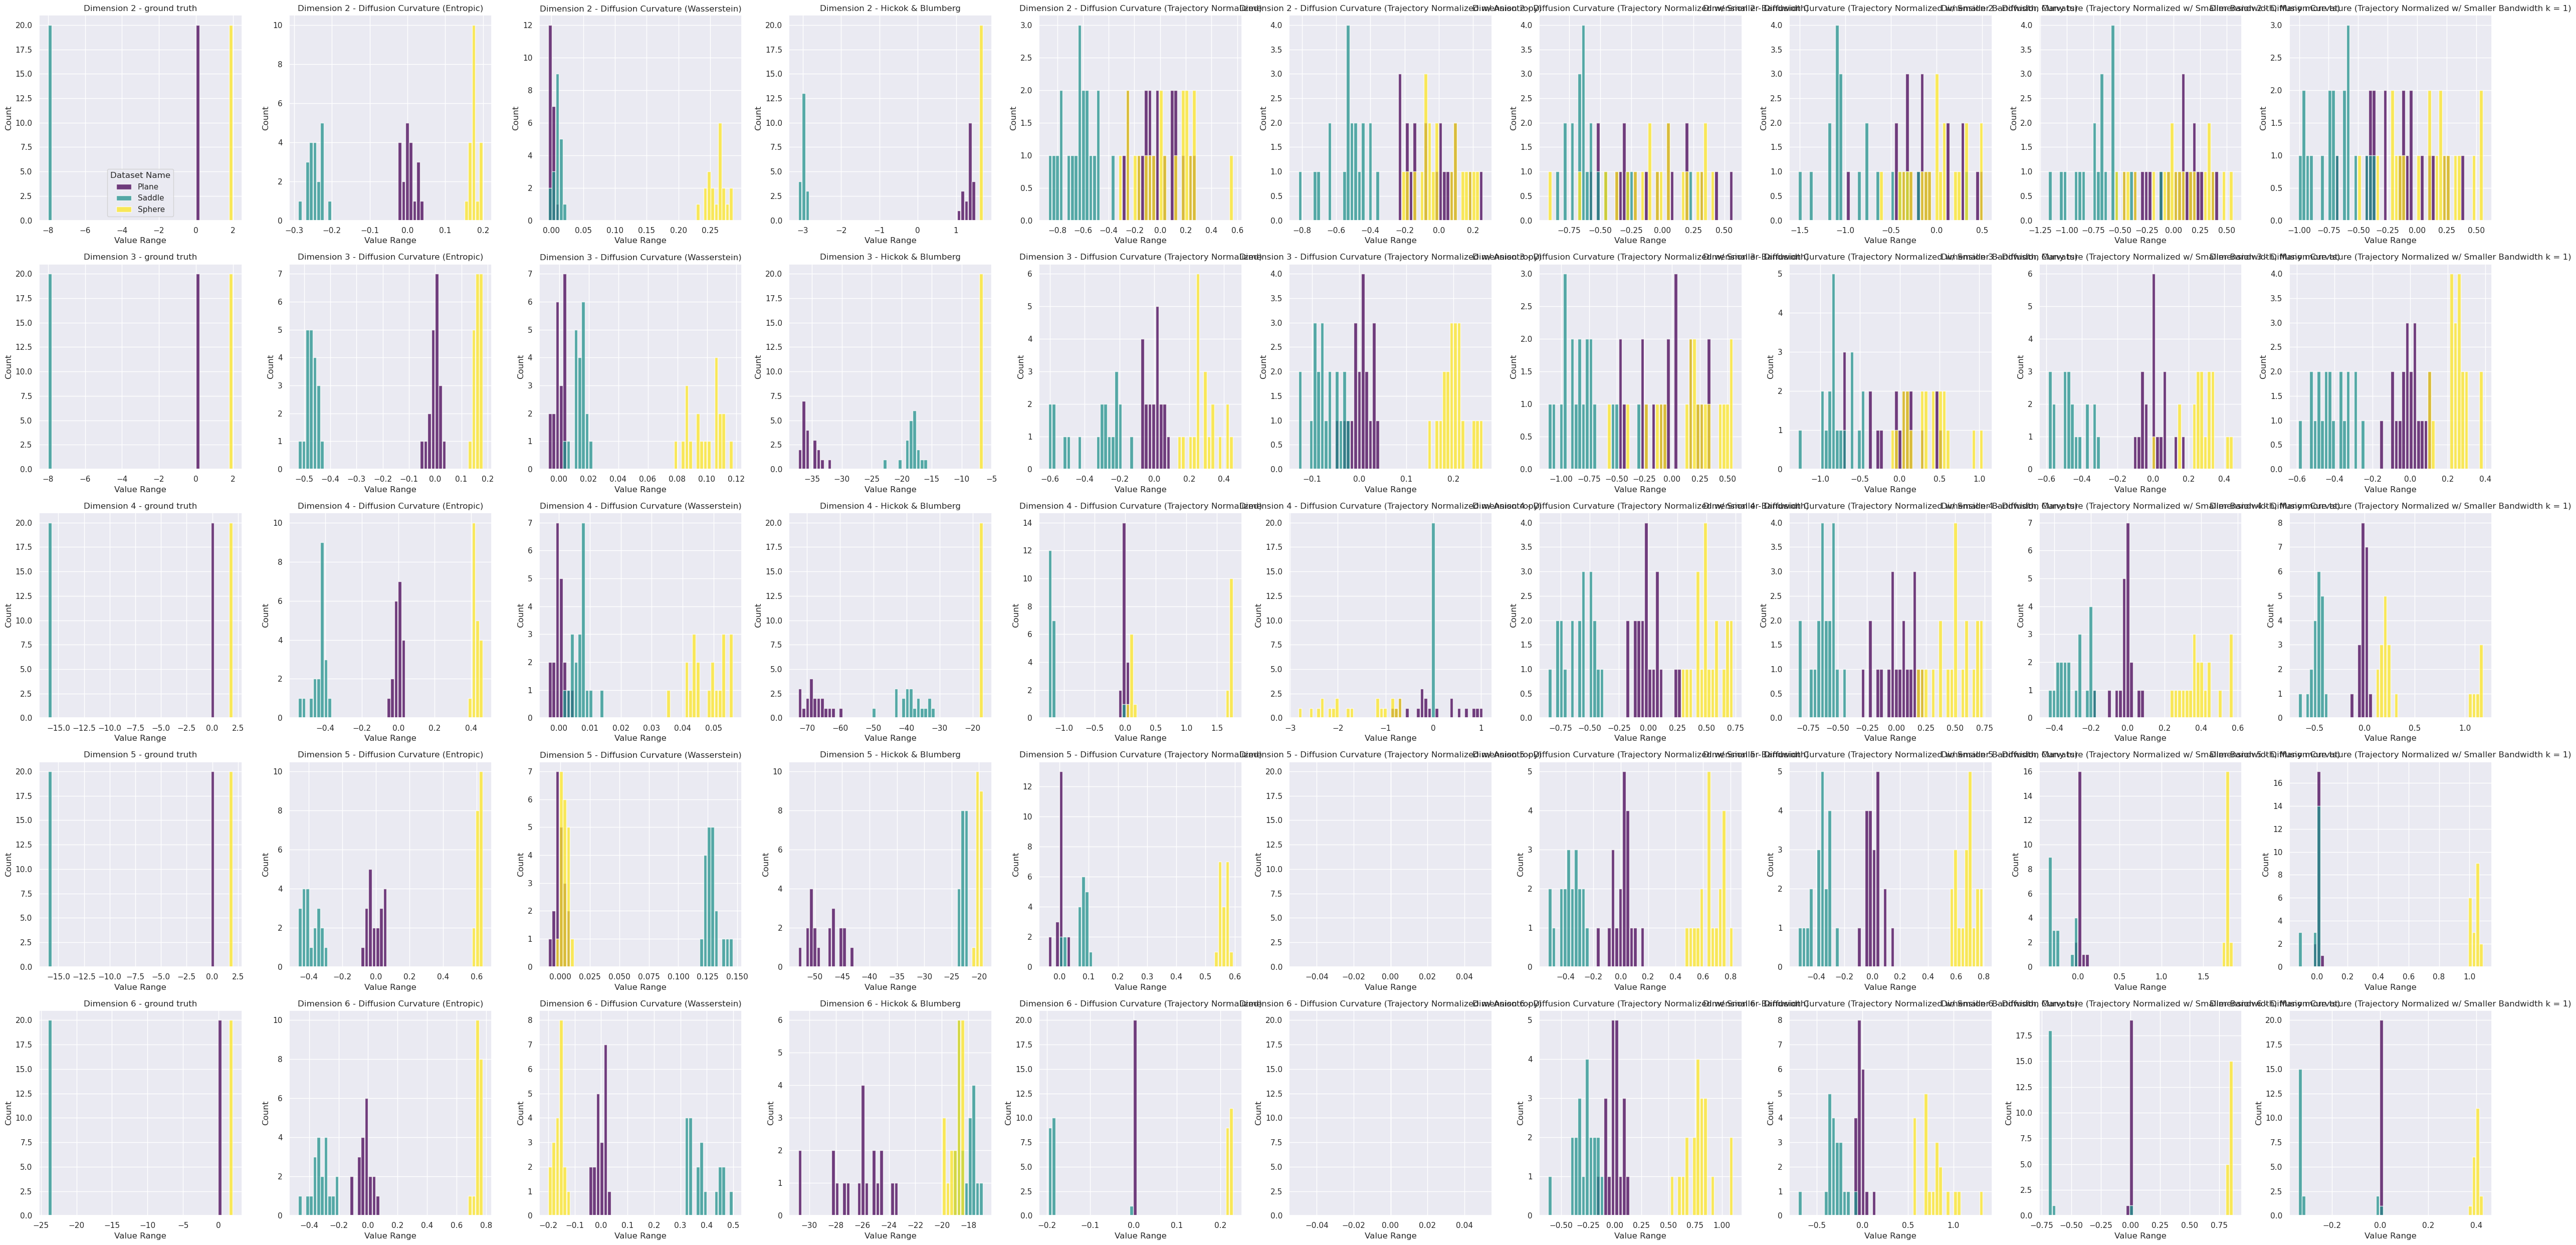

In [ ]:
#| label: fig-sadspheres
#| fig-cap: Predicted curvatures of Saddles and Spheres in dimensions 2-6. Diffusion Curvature robustly distinguishes between the signs of the data, even in high dimensions, and with relative sparsity.
#| fig-alt: ...
SS1._aggregate_labels()
SS1.plot_by_dimension()

# Conclusion